In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.tsa.api import SARIMAX

In [2]:
palette_tab10 = sns.color_palette("tab10", 10)
cmap = sns.color_palette([palette_tab10[0], palette_tab10[1]], as_cmap=True)
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

Read the data

In [3]:
DIR_SUBJECT_1 = '../udataset/meat/production.csv'
# DIR_SUBJECT_1 = '../udataset/meat/cold_storage.csv'
# DIR_SUBJECT_1 = '../udataset/meat/slaughter.csv'
# DIR_SUBJECT_1 = '../udataset/meat/weights.csv'
df_subject1 = pd.read_csv(DIR_SUBJECT_1)
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Other Chicken,Turkey,Red Meat,Poultry
0,1921-01,3.580000e+08,27000000.0,5.650000e+08,44000000.0,NaN,NaN,393000000.0,9.940000e+08,3.930000e+08
1,1921-02,2.790000e+08,24000000.0,4.840000e+08,39000000.0,NaN,NaN,NaN,8.260000e+08,0.000000e+00
2,1921-03,3.400000e+08,31000000.0,3.720000e+08,45000000.0,NaN,NaN,NaN,7.880000e+08,0.000000e+00
3,1921-04,3.160000e+08,29000000.0,3.740000e+08,41000000.0,NaN,NaN,NaN,7.600000e+08,0.000000e+00
4,1921-05,3.190000e+08,31000000.0,3.960000e+08,37000000.0,NaN,NaN,NaN,7.830000e+08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,51100000.0,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,48400000.0,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,50600000.0,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,44500000.0,500300000.0,4.638900e+09,4.362100e+09


In [4]:
# DIR_SUBJECT_2 = '../udataset/unemployment_month_US.csv'
# DIR_SUBJECT_2 = '../dataset/youth_unemployment_rate.csv'
DIR_SUBJECT_2 = '../dataset/national_hourly_earnings.csv'
df_subject2 = pd.read_csv(DIR_SUBJECT_2)
df_subject2

,YearMonth,HourlyEarnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Make variables for specific dataset 1

In [5]:
# For meat production
df_subject1 = df_subject1.drop(columns=['Other Chicken'])
df_subject1 = df_subject1.dropna()
MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']
SUBJECT1 = 'meat_production'
UNIT = 'Pounds'

# For meat cold storage
# MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'frozen_egg', 'red_meat', 'poultry']

SUBJECT_TITLE1 = SUBJECT1.replace('_', ' ').title()
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Turkey,Red Meat,Poultry
648,1977-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
649,1977-02,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
650,1977-03,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
651,1977-04,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
652,1977-05,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


Make variables for specific dataset 2

In [6]:
# # For unemployment_month_US.csv
# df_subject2 = df_subject2.rename(columns={'Year-Month': 'datetime'})
# SUBJECT2 = 'unemployment_rate'

# # For youth_unemployment_rate.csv
# df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'UnemploymentRate': 'unemployment_rate'})
# SUBJECT2 = 'unemployment_rate'

# For national_hourly_earnings.csv
df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'HourlyEarnings': 'hourly_earnings'})
SUBJECT2 = 'hourly_earnings'

SUBJECT_TITLE2 = SUBJECT2.replace('_', ' ').title()
df_subject2

,datetime,hourly_earnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Change label format to be lower + underscores instead of space

In [7]:
df_subject1.columns = df_subject1.columns.str.lower().str.replace(' ', '_')
df_subject2.columns = df_subject2.columns.str.lower().str.replace(' ', '_')

Change date format to better use together

In [8]:
df_subject1['datetime'] = pd.to_datetime(df_subject1['datetime'])
df_subject2['datetime'] = pd.to_datetime(df_subject2['datetime'])
df_subject2

,datetime,hourly_earnings
0,2006-03-01,20.07
1,2006-04-01,20.36
2,2006-05-01,20.06
3,2006-06-01,20.04
4,2006-07-01,20.28
...,...,...
212,2023-11-01,34.08
213,2023-12-01,34.26
214,2024-01-01,34.67
215,2024-02-01,34.61


In [9]:
df_subject1.reset_index(drop=True, inplace=True)
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
0,1977-01-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
1,1977-02-01,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
2,1977-03-01,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
3,1977-04-01,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
4,1977-05-01,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
551,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
552,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
553,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
554,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


# Stationary analysis

Check for stationarity

In [10]:
def test_stationarity(timeseries, title, verbose=False):
    title = title.replace('_', ' ').title()

    result = adfuller(timeseries, autolag='AIC')
    adf_stat = result[0]
    p_val = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_val = result[4]
    icbest = result[5]

    if verbose:
        # Print the results in a more structured report format
        print(f"Augmented Dickey-Fuller Test Results for {title}:")
        print("-------------------------------------")
        print(f"Test Statistic: {adf_stat:.4f}")
        print(f"P-value: {p_val:.4f}")
        print(f"Number of Lags Used: {used_lag}")
        print(f"Number of Observations Used: {n_obs}")
        print("Critical Values:")
        for key, value in critical_val.items():
            print(f"    {key} ({value:.4f})")
        print(f"Information Criterion (best): {icbest:.4f}")
        print("Conclusion:")
        if p_val < 0.05:
            print("The time series is stationary with 95% confidence.")
        else:
            print("The time series is not stationary. Consider differencing or detrending.")

    if p_val < 0.05:
        return 1
    else:
        return 0

# ARIMA

Split train test data

In [11]:
decomposition = seasonal_decompose(df_subject2[SUBJECT2], model='additive', period=12)
earning_resid = df_subject2.copy()
earning_resid = earning_resid[['datetime']]
earning_resid['resid_earn'] = decomposition.resid

decomposition = seasonal_decompose(df_subject1[MEAT_TYPE[0]], model='additive', period=12)
beef_resid = df_subject1.copy()
beef_resid = beef_resid[['datetime']]
beef_resid['resid_beef'] = decomposition.resid

earning_resid.dropna(inplace=True)
beef_resid.dropna(inplace=True)

print(beef_resid, earning_resid)

      datetime    resid_beef
6   1977-07-01 -3.659948e+07
7   1977-08-01  2.513886e+08
8   1977-09-01  5.447126e+07
9   1977-10-01 -4.951751e+07
10  1977-11-01 -2.496681e+07
..         ...           ...
545 2023-02-01  1.318106e+07
546 2023-03-01  1.811505e+08
547 2023-04-01 -9.009894e+07
548 2023-05-01  5.092543e+07
549 2023-06-01  1.663249e+07

[544 rows x 2 columns]       datetime  resid_earn
6   2006-09-01   -0.019051
7   2006-10-01    0.084450
8   2006-11-01   -0.026261
9   2006-12-01    0.039989
10  2007-01-01   -0.091064
..         ...         ...
206 2023-05-01   -0.097878
207 2023-06-01   -0.065795
208 2023-07-01    0.260112
209 2023-08-01   -0.012780
210 2023-09-01   -0.032384

[205 rows x 2 columns]


In [12]:
merged_df = beef_resid.merge(earning_resid, on='datetime', how='inner')
train_df = merged_df[merged_df['datetime'].dt.year <= 2017]
test_df = merged_df[(merged_df['datetime'].dt.year > 2017) & (merged_df['datetime'].dt.year <= 2018)]

print(train_df.shape, test_df.shape)

(136, 3) (12, 3)


Do ARIMA for beef in forecasting wages

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24302D+00    |proj g|=  6.21810D+12

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0   6.218D+12  -1.243D+00
  F =  -1.2430190382148021     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Figure(1200x700)


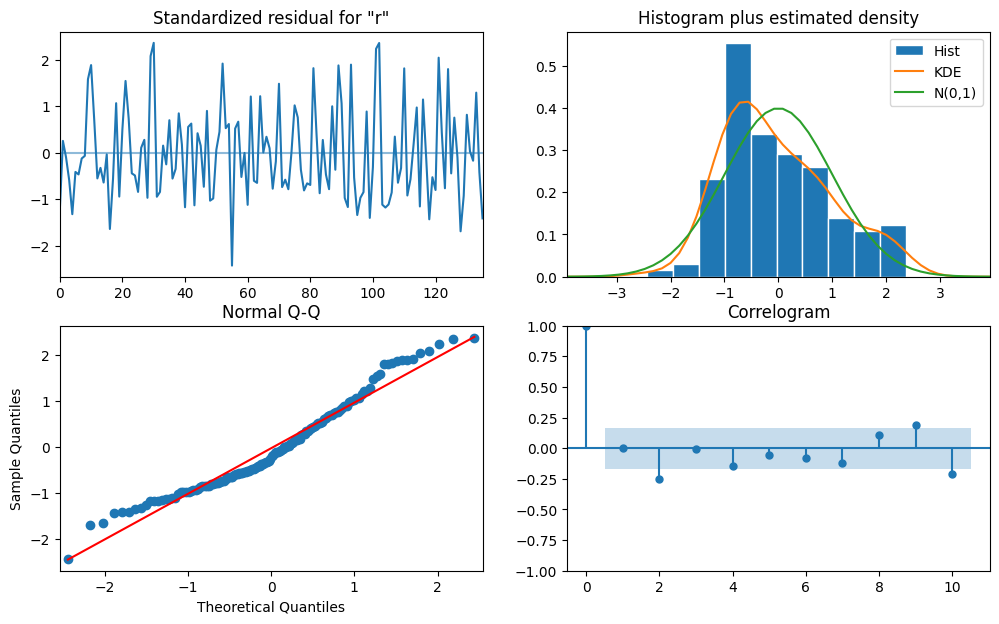

In [13]:
y = train_df['resid_earn']
x = train_df['resid_beef']

p, d, q = 1, 0, 1
P, D, Q, s = 0, 0, 0, 12

model = SARIMAX(y, exog=x,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=True,
                enforce_invertibility=True)
model_fit = model.fit(method='lbfgs')
print(model_fit.plot_diagnostics(figsize=(12, 7)))

In [14]:
forecast = model_fit.get_forecast(steps=len(test_df), exog=test_df['resid_beef'])
predict_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()
predict_mean

136   -0.048414
137    0.025080
138   -0.017032
139    0.008398
140   -0.045370
141    0.005281
142    0.015990
143   -0.057476
144    0.105559
145   -0.026594
146   -0.043261
147    0.072087
Name: predicted_mean, dtype: float64

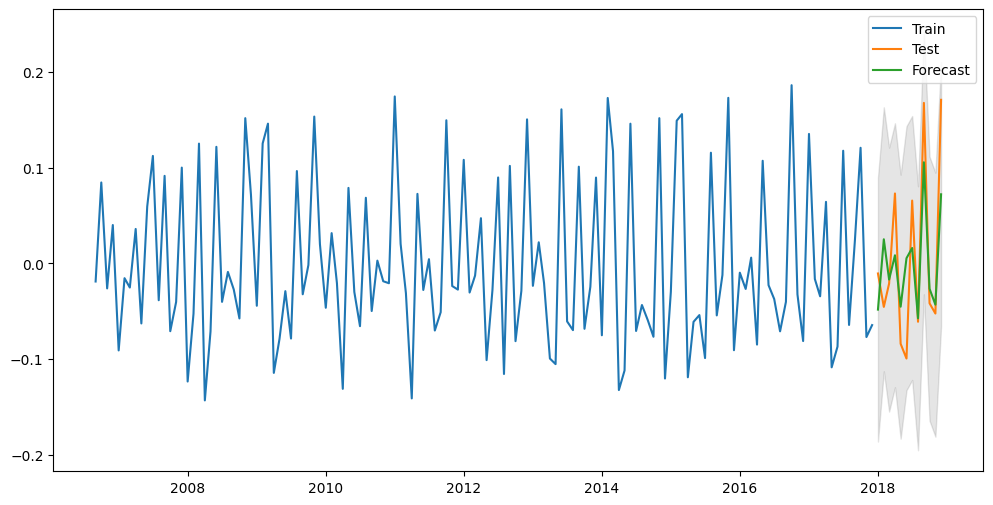

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['datetime'], train_df['resid_earn'], label='Train')
plt.plot(test_df['datetime'], test_df['resid_earn'], label='Test')
plt.plot(test_df['datetime'], predict_mean, label='Forecast')
plt.fill_between(test_df['datetime'], confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='k', alpha=0.1)
# plt.title(f'{SUBJECT_TITLE2} Forecasting with {MEAT_TYPE[0]}')
plt.legend()
plt.show()